In [1]:
%load_ext autoreload
%autoreload 2

from score_models.plot_utils import *
from score_models.toy_distributions import *
from score_models import MLP, MLPv2, ScoreModel, VESDE, VPSDE, CosineVPSDE
import torch
plt.style.use('dark_background')

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

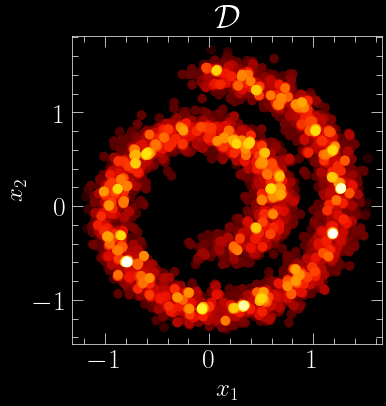

In [3]:
distribution = swiss_roll()

D = int(2**12)
data = distribution.sample((D,))
dataset = Dataset(data)

ax = plot_scatter(data, bins=100)
ax.set_title(r"$\mathcal{D}$")
ax.set_ylabel(r"$x_2$")
ax.set_xlabel(r"$x_1$");


In [4]:
C = 2
layers = 4
width = int(2**7)
fourier_scale = 0.02

sde = VESDE(1e-2, 10)
# sde = VPSDE(1e-2, 20, epsilon=1e-5)
# sde = CosineVPSDE(100, epsilon=1e-3)
net = MLPv2(C, layers=layers, width=width, fourier_scale=fourier_scale)
model = ScoreModel(net, sde, formulation="edm")

In [5]:
E = 300
lr = 1e-3
batch_size = int(2**8)
# ema_decay = 0.99
ema_lengths = (0.05, 0.1)
path = "test_swiss_roll_model"

losses = model.fit(
    dataset, 
    path=path,
    epochs=E,
    learning_rate=lr,
    batch_size=batch_size, 
    ema_lengths=ema_lengths,
    noise_level_distribution="normal",
    checkpoints=10,
    models_to_keep=50,
    log_sigma_mean=-1,
    log_sigma_std=0.5
    )

Sampling noise level from log-Normal with mean log sigma = -1 and standard deviation 0.5 (base 10)
Using Karras EMA with ema lengths [0.05,0.10]


Epoch 300 | Cost: 7.9e-01 | time per step 0.0098 s |: 100%|██████████| 300/300 [00:45<00:00,  6.63it/s]

Finished training after 0.013 hours.


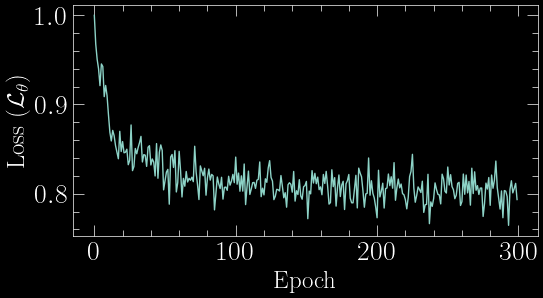

In [6]:
plt.figure(figsize=(6, 3))
plt.plot(losses)
plt.ylabel(r"Loss ($\mathcal{L}_\theta$)")
plt.xlabel("Epoch");

In [7]:
model = ScoreModel(path=path, ema_length=0.1)

Initialized architecture MLPv2 model with 0.17M parameters from test_swiss_roll_model.
Synthesized the neural network with EMA length 0.10.


In [8]:
samples = model.sample(shape=(D, C), steps=200)

t=0.005 | sigma=0.01 | x=0.2±1: 100%|██████████| 200/200 [00:03<00:00, 63.46it/s]


t=0.9 | sigma=7 | x=-2±1e+01: 100%|██████████| 20/20 [00:01<00:00, 13.12it/s]  


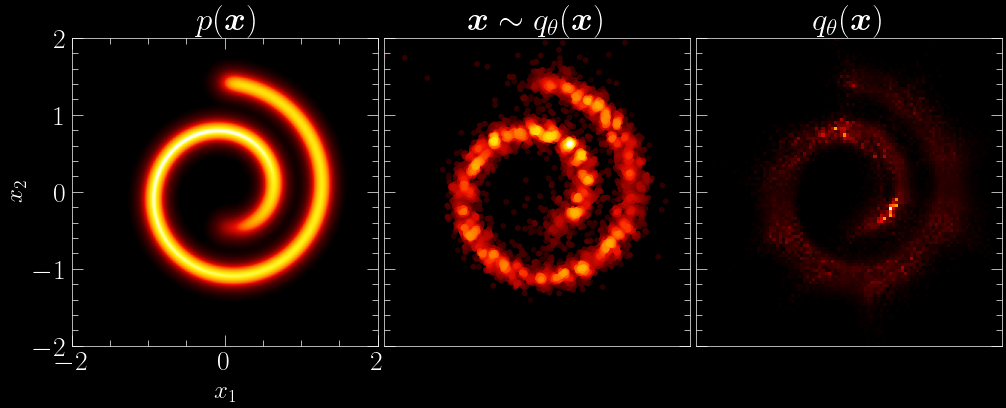

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
extent = (-2, 2, -2, 2)

plot_density(distribution.log_prob, bins=200, extent=extent, ax=ax0);
plot_scatter(samples, bins=200, ax=ax1, extent=extent, s=10);
plot_density(lambda x: model.log_prob(x, steps=20), bins=100, extent=extent, ax=ax2);

ax0.set_xlabel(r"$x_1$")
ax0.set_ylabel(r"$x_2$")
ax1.set_xticks([])
ax2.set_xticks([])
ax0.set_title(r"$p(\bm{x})$")
ax1.set_title(r"$\bm{x} \sim q_\theta(\bm{x})$")
ax2.set_title(r"$q_\theta(\bm{x})$")

plt.subplots_adjust(wspace=0.02);